# Does SSA (Sistem Satu Arah - Unidirectional Road System) implementation on some road segments in Depok city make any improvement to the traffic condition of the city?

- Comparing the traffic conditions (in terms of travel time) between various locations in Depok city before (< July 2017) and after (> July 2017) the implementation of SSA
- Using HERE REST API to derive past traffic conditions

### Limitations
Apparently HERE REST API only provides precise historical travel times from 1 January 2018 onward. Travel times before that time are averaged out and categorised into 'morning travel' and 'evening travel'.

# data prep

In [1]:
import pandas as pd
import numpy as np
import sys
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_heatmap
%matplotlib inline

df = pd.read_csv('data_2017_2018.csv')

In [2]:
def get_day(dt):
    year, month, day = (int(x) for x in dt.split('-'))
    day_no = datetime.date(year, month, day).weekday()
    return calendar.day_name[day_no]

In [3]:
time_groups_dict = {'Monday_Morning': '01_Monday_Morning',
                    'Monday_Evening': '02_Monday_Evening',
                    'Wednesday_Morning': '03_Wednesday_Morning',
                    'Wednesday_Evening': '04_Wednesday_Evening',
                    'Friday_Morning': '05_Friday_Morning',
                    'Friday_Evening': '06_Friday_Evening',
                    'Saturday_Morning': '07_Saturday_Morning',
                    'Saturday_Evening': '07_Saturday_Evening'}

In [8]:
df['year'] = df['clock_time'].apply(lambda t: int(t[:4]))
df['time_of_day'] = df['clock_time'].apply(lambda t: 'Morning' if int(t[11:13]) < 10 else 'Evening')
df['day'] = df['clock_time'].apply(lambda t: get_day(t[:10]))
df['time_groups'] = df['day'] + '_' + df['time_of_day']
df['time_groups'] = df['time_groups'].map(time_groups_dict)

## list of points within the analysis

In [9]:
for i in sorted(set(list(df['From']))): print(i)

01 pertigaan juanda-margonda arah ramanda
02 pertigaan ramanda arah terminal depok
03 pertigaan ramanda arah depok mall
04 pasar baru jln nusantara
05 jln raya sawangan
06 rumah (sarikaya)
07 dewi sartika, perlimaan, lajur lama
08 dewi sartika, perlimaan, lajur baru
09 jln kartini - dewi sartika, arah margonda
10 jln kartini - dewi sartika, arah citayam
11 ITC depok
12 sebrang ITC depok


## Aggregate changes between each day-time of day combinations

median values are shown under each boxplot


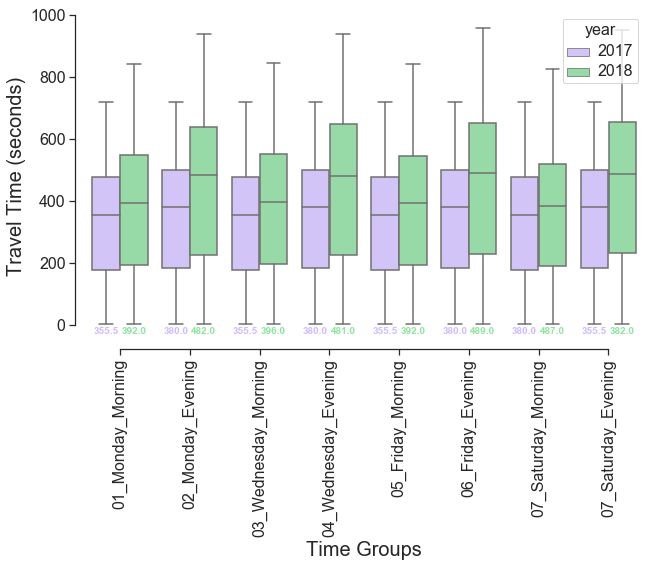

In [11]:
sns.set(style="ticks", palette="pastel")

fig, ax = plt.subplots(figsize=(10,6))

g = sns.boxplot(x='time_groups', y='time', hue='year', palette=['m','g'], data=df)

sns.despine(offset=10, trim=True)

for item in g.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(16)
    
for item in g.get_yticklabels():
    item.set_fontsize(16)
    
plt.xlabel('Time Groups', fontsize=20)
plt.ylabel('Travel Time (seconds)', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

# MEDIAN SERIES
pctl50 = df.groupby(['time_groups', 'year'])['time'].quantile(0.5)
pctl50_labels = [str(np.round(s, 2)) for s in pctl50]

# GROUP INDEX TUPLES
grps = [(i, 2*i, 2*i+1) for i in range(8)]
pos = range(len(pctl50))

# ADJUST HORIZONTAL ALIGNMENT WITH MORE SERIES
for tick, label in zip(grps, ax.get_xticklabels()):
    ax.text(tick[0]-0.2, -30, pctl50_labels[tick[1]], 
               ha='center', size='small', color='m', weight='semibold')
    ax.text(tick[0]+0.2, -30, pctl50_labels[tick[2]], 
               ha='center', size='small', color='g', weight='semibold')
    
print('median values are shown under each boxplot')

## changes between each origin-destination points

In [6]:
#data prep
df_2017 = df.loc[df['year']==2017]
df_2017_raw = df_2017.groupby(['From', 'To'])['time'].median().unstack(level=1)
df_2017_raw.fillna(0, inplace=True)

df_2018 = df.loc[df['year']==2018]
df_2018_raw = df_2018.groupby(['From', 'To'])['time'].median().unstack(level=1)
df_2018_raw.fillna(0, inplace=True)

difference_raw = df_2018_raw - df_2017_raw
difference_perc = difference_raw / df_2017_raw
difference_perc.fillna(0, inplace=True)

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x143d65db8d0>)

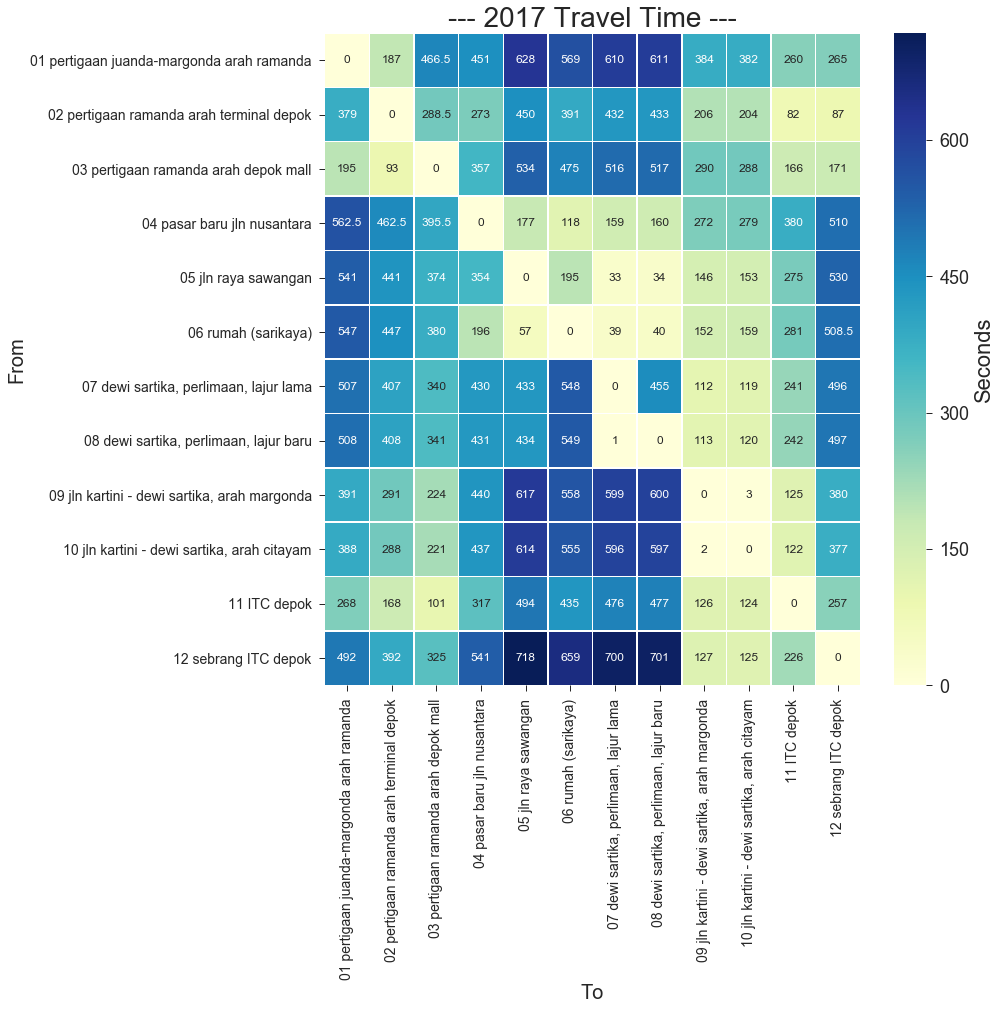

In [7]:
plot_heatmap(df_2017_raw, '--- 2017 Travel Time ---')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x143d88f57b8>)

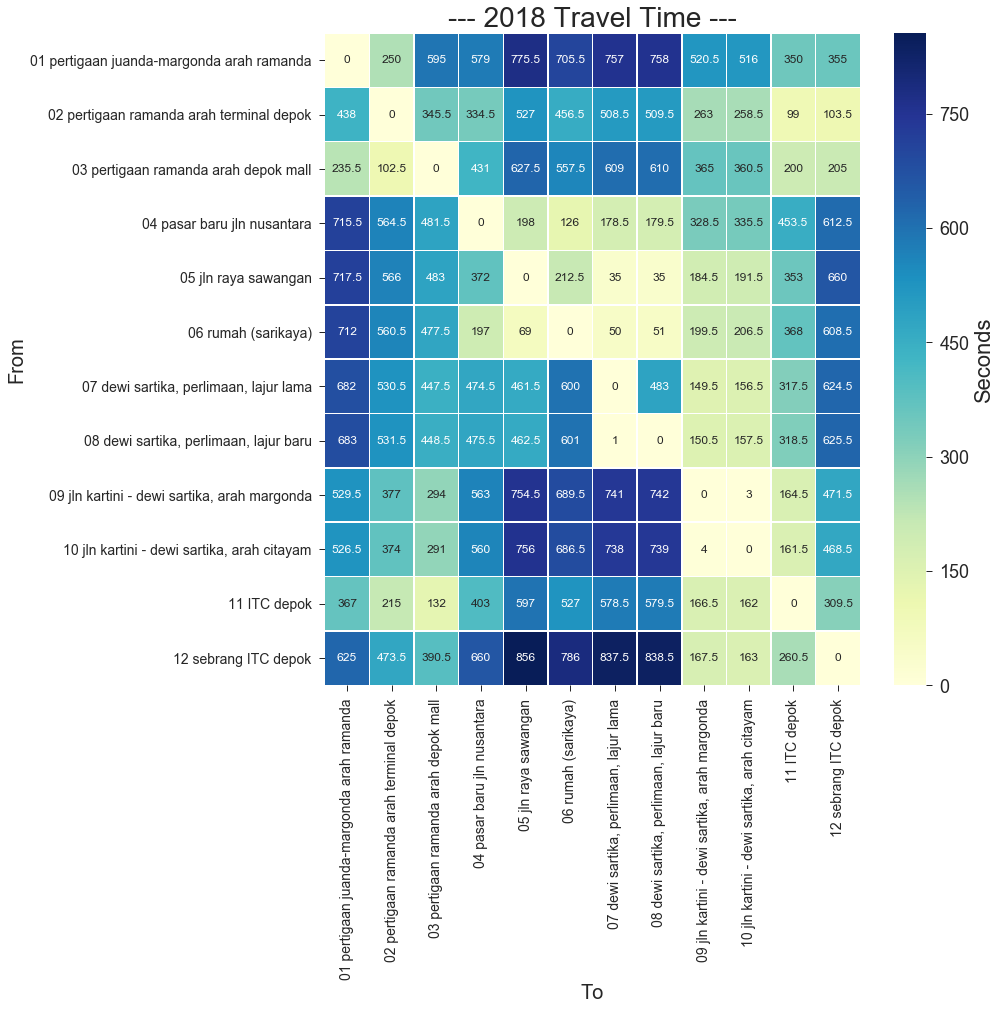

In [8]:
plot_heatmap(df_2018_raw, '--- 2018 Travel Time ---')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x143d8cfacc0>)

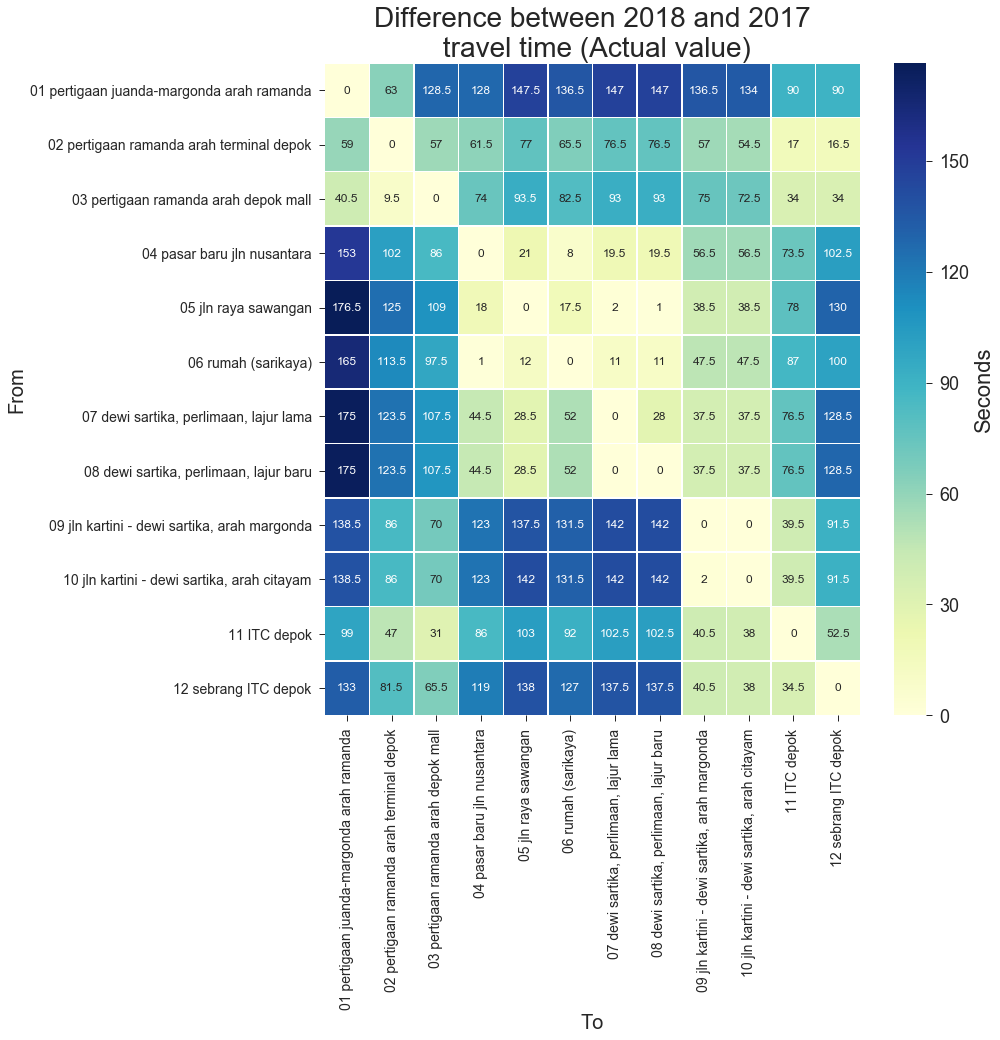

In [9]:
plot_heatmap(difference_raw, 'Difference between 2018 and 2017\n travel time (Actual value)')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x143d8e74710>)

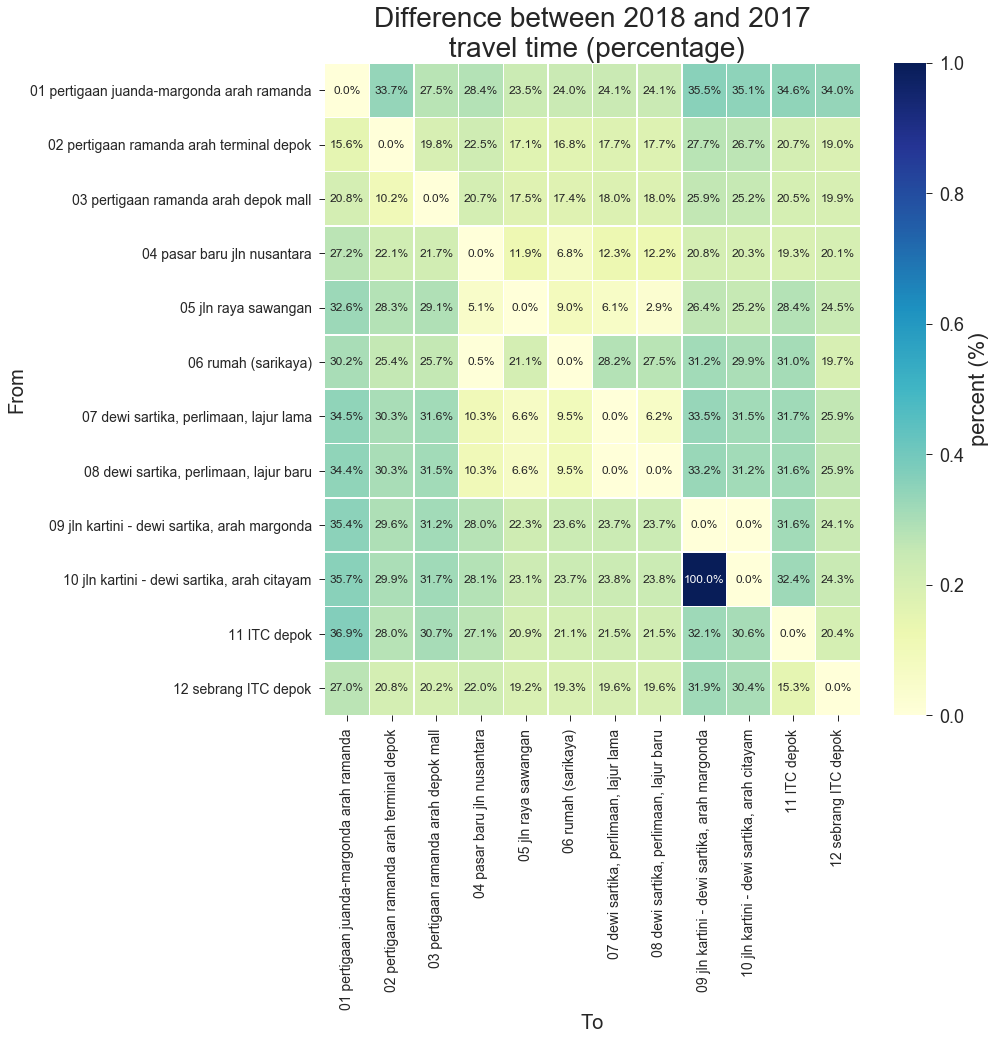

In [10]:
plot_heatmap(difference_perc, 'Difference between 2018 and 2017\n travel time (percentage)',
             cbarlabel='percent (%)', fmt='.1%')

## which origin points are impacted the most?

In [11]:
difference_raw.sum(axis=1).sort_values(ascending=False)

From
01 pertigaan juanda-margonda arah ramanda       1348.0
10 jln kartini - dewi sartika, arah citayam     1108.0
09 jln kartini - dewi sartika, arah margonda    1101.5
12 sebrang ITC depok                            1052.0
07 dewi sartika, perlimaan, lajur lama           839.0
08 dewi sartika, perlimaan, lajur baru           811.0
11 ITC depok                                     794.0
05 jln raya sawangan                             734.0
03 pertigaan ramanda arah depok mall             701.5
04 pasar baru jln nusantara                      698.0
06 rumah (sarikaya)                              693.0
02 pertigaan ramanda arah terminal depok         618.0
dtype: float64

## which destination points are impacted the most?

In [12]:
difference_raw.sum(axis=0).sort_values(ascending=False)

To
01 pertigaan juanda-margonda arah ramanda       1453.0
12 sebrang ITC depok                             965.5
02 pertigaan ramanda arah terminal depok         960.5
03 pertigaan ramanda arah depok mall             929.5
05 jln raya sawangan                             928.5
08 dewi sartika, perlimaan, lajur baru           900.0
06 rumah (sarikaya)                              896.0
07 dewi sartika, perlimaan, lajur lama           873.0
04 pasar baru jln nusantara                      822.5
11 ITC depok                                     646.0
09 jln kartini - dewi sartika, arah margonda     569.0
10 jln kartini - dewi sartika, arah citayam      554.5
dtype: float64